# A notebook for exploring fuel data
In this notebook, we are looking to discover data values regarding fuel usage that can be obtained from CAN bus.

In [16]:
import binascii
import bitstring
import time
import datetime
import serial
import csv
import numpy as np
import matplotlib
#matplotlib.use("nbagg")
import matplotlib.pyplot as plt

import pandas as pd # Note that this is not commai Panda, but Database Pandas
import cantools 
import matplotlib.animation as animation
from matplotlib import style
import uuid

In [17]:
import strym.DBC_Read_Tools as DBC
from datetime import datetime

def dateparse(ts):
    # if you encounter a "year is out of range" error the timestamp
    # may be in milliseconds, try `ts /= 1000` in that case
    ts = float(ts)
    d = datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S:%f')
    return d

## The files in question were recorded over three different times
There were four driving tests, from between Points A and B. During each drive, the 

1. Drive as instructed w/ only Techstream connected (Drive from A to B with bursts of fuel to get up to ~40mph and then let off the accelerator pedal)
2. turn the libpanda on, then start up Techstream and record a drive as instructed (Drive from B to A)
3. Drive from A to B but only w/ libpanda
4. Drive from B to A but only w/ libpanda

### Drive 1
Began ~ 13:19 MST on 8/13/2020, ending after approximately 6:38 min:sec.
Drive from Kolb/Sunrise to near Craycroft/Sunrise, West along Sunrise. This drive is recorded *only* by Toyota Techstream

### Drive 2, 2020-08-13-13-26-45_2T3Y1RFV8KC014025_CAN_Messages
Began ~ 13:28 MST on 8/13/2020, ending after approximately 9:16 min:sec.
From near Craycroft/Sunrise to Kolb/Sunrise, East along Sunrise. This drive also has data recorded from the Toyota Techstream software.

### Drive 3, 2020-08-13-13-38-37_2T3Y1RFV8KC014025_CAN_Messages
Began ~ 13:38 MST on 8/13/2020, ending after approximately 9:40 min:sec

### Drive 4, 2020-08-13-13-48-16_2T3Y1RFV8KC014025_CAN_Messages
Began ~ 13:48 MST on 8/13/2020, ending after approximately 6:33 min:sec
From near Craycroft/Sunrise to Kolb/Sunrise, East along Sunrise. This drive also has data recorded from the Toyota Techstream software.



In [18]:
drive3start=1597350406.108452
datetime.fromtimestamp(drive3start)

datetime.datetime(2020, 8, 13, 13, 26, 46, 108452)

In [20]:
drive2file = '/Users/sprinkle/work/data/cyverse/rahulbhadani/JmscslgroupData/PandaData/2020_08_13/2020-08-13-13-26-45_2T3Y1RFV8KC014025_CAN_Messages.csv'
drive3file = '/Users/sprinkle/work/data/cyverse/rahulbhadani/JmscslgroupData/PandaData/2020_08_13/2020-08-13-13-38-37_2T3Y1RFV8KC014025_CAN_Messages.csv'
#can_data = pd.read_csv(fileName, parse_dates=[0], date_parser=dateparse)# read in the data
can_data_all = pd.read_csv(drive2file)# read in the data

dbcfile = '../examples/newToyotacode_experiment.dbc'
db_file = cantools.db.load_file(dbcfile)# Specify your dbc file

In [21]:
# need the .copy() so that we don't end up with phantom reads that python creates without
# the intelligence of a stdcpp impl that would defer copy to copy-on-write and thus 
# avoid all this documentation nonsense...
can_data = can_data_all[0:-1].copy()

In [22]:
can_data['ClockTime'] = can_data['Time'].apply(dateparse)
can_data

,Time,Bus,MessageID,Message,MessageLength,ClockTime
0,1.597350e+09,2,835,0000430000000091,8.0,2020-08-13 13:26:46:108452
1,1.597350e+09,0,835,0000430000000091,8.0,2020-08-13 13:26:46:108452
2,1.597350e+09,2,705,08ff86ff8cbc009f,8.0,2020-08-13 13:26:46:108452
3,1.597350e+09,0,705,08ff86ff8cbc009f,8.0,2020-08-13 13:26:46:108452
4,1.597350e+09,2,452,0383260838007f38,8.0,2020-08-13 13:26:46:108794
...,...,...,...,...,...,...
2509593,1.597351e+09,1,441,de7ffc00000ffc26,8.0,2020-08-13 13:37:17:848951
2509594,1.597351e+09,1,442,de7ffc00000ffc27,8.0,2020-08-13 13:37:17:849765
2509595,1.597351e+09,2,401,e2ff8830646400fb,8.0,2020-08-13 13:37:17:849765
2509596,1.597351e+09,0,401,e2ff8830646400fb,8.0,2020-08-13 13:37:17:849765


In [23]:
velocity = DBC.convertData('SPEED',1,can_data,db_file)
vel_t = velocity['Time'].values
vel_data = velocity['Message'].values
# find the first velocity value over 40km/hr
# puts the time in the same timeseries through a zip, and returns the 
# first time we are > 40 km/hr
vel_ndx = next( i for i,vel in zip(vel_t,vel_data) if vel > 40 )

# this is the first element of the array where our velocity is over 40 km/hr
i = np.where(vel_data > 40)[0][0]
i

24980

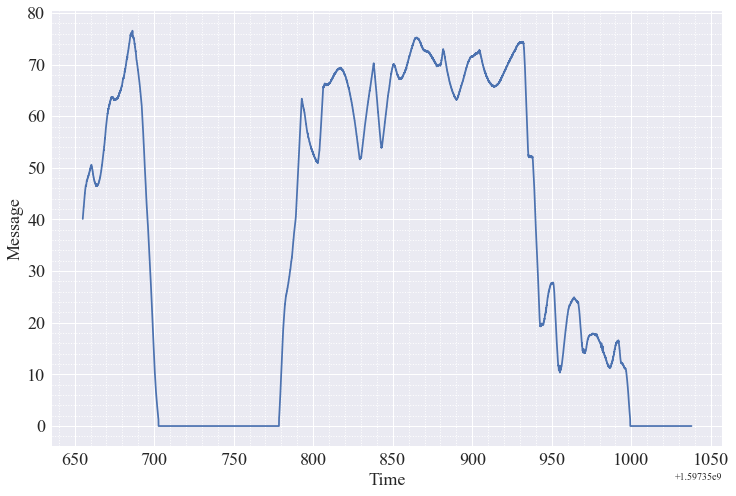

In [24]:
# just to prove it:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (12,8)
params = {'legend.fontsize': 18,
  'legend.handlelength': 2}
plt.rcParams.update(params)
plt.rcParams["font.family"] = "Times New Roman"
fig =plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
ax.grid(which='minor', linestyle=':')
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Message', fontsize=18)
plt.plot(vel_t[i:-1],vel_data[i:-1])
#ndx = next ( index(tim) for tim in velocity['Time'].values if velocity['Message'].values[tim] == vel_val )
#ndx

In [25]:
# this is the first element of the array where our velocity is really small
ii = i + np.where(vel_data[i:] <= 0.01)[0][0]
ii

29740

In [26]:
# now find the next time where it is >5 and start plotting again
iii = ii + np.where(vel_data[ii:] > 5 )[0][0]
drive3start=iii
print(f'The first index is {iii}')


The first index is 37386


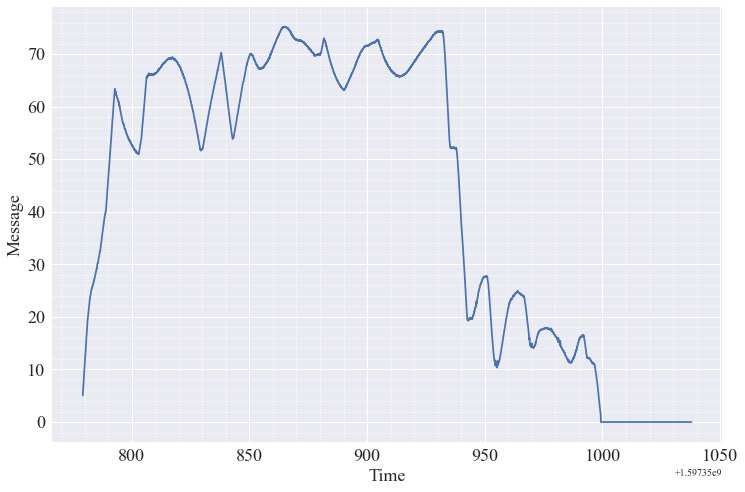

In [27]:
# just to prove it:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (12,8)
params = {'legend.fontsize': 18,
  'legend.handlelength': 2}
plt.rcParams.update(params)
plt.rcParams["font.family"] = "Times New Roman"
fig =plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
ax.grid(which='minor', linestyle=':')
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Message', fontsize=18)
plt.plot(vel_t[iii:],vel_data[iii:])

In [28]:
starttime = vel_t[iii]
endtime=starttime+100
print(f'Starting at {starttime}, ending at {endtime}')

Starting at 1597350779.1810439, ending at 1597350879.1810439


In [33]:
dbcfile = '../examples/newToyotacode_experiment.dbc'

#identify starting time for all can_data, not just that thread
can_data_start_ndx = np.where(can_data['Time'] > starttime)[0][0]
can_data_end_ndx = np.where(can_data['Time'] > endtime)[0][0]

In [34]:
#%pip install ipympl
# If using JupyterLab
#%conda install nodejs
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
#!jupyter labextension install jupyter-matplotlib
#!jupyter lab build
!jupyter labextension list

JupyterLab v2.1.5
Known labextensions:
   app dir: /Users/sprinkle/opt/anaconda3/share/jupyter/lab
        @jupyter-widgets/jupyterlab-manager v2.0.0  enabled  OK
        jupyter-gmaps v0.9.0  enabled  OK
        jupyter-matplotlib v0.7.3  enabled  OK


1597350779.18346 is the first time


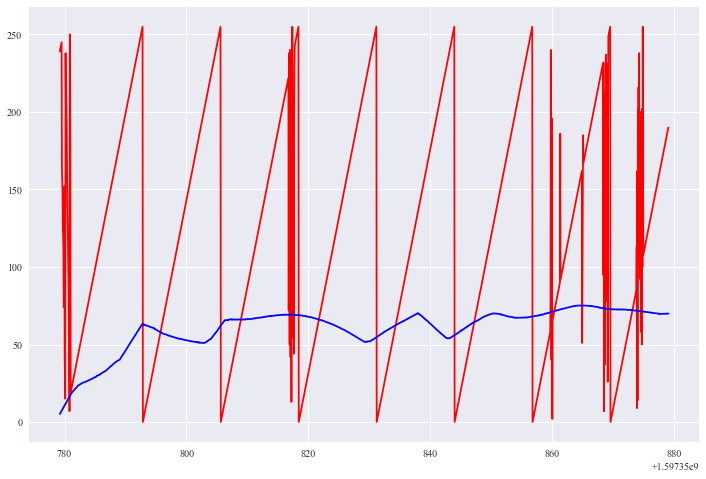

In [35]:
#%matplotlib notebook
db_file = cantools.db.load_file(dbcfile)# Specify your dbc file
_439 = DBC.convertData('UNKNOWN_439','CHECKSUM',can_data[can_data_start_ndx:can_data_end_ndx],db_file)
_speed = DBC.convertData('SPEED','SPEED',can_data[can_data_start_ndx:can_data_end_ndx],db_file)

print(f'{_439["Time"].values[0]} is the first time')
plt.plot(_439['Time'],_439['Message'],'r',_speed['Time'],_speed['Message'],'b')

In [16]:
decimalData_STEER_ANGLE = DBC.convertData('STEER_ANGLE_SENSOR',0, can_data, db_file)
decimalData_STEER_FRACTION = DBC.convertData('STEER_ANGLE_SENSOR',1, can_data, db_file)
decimalData_STEER_RATE = DBC.convertData('STEER_ANGLE_SENSOR',2, can_data, db_file)

In [51]:
Steering_Rate_Time = decimalData_STEER_RATE['Time'].values
Steering_Rate_Message = decimalData_STEER_RATE['Message'].values

In [52]:
Steering_Angle_Time = decimalData_STEER_ANGLE['Time'].values
Steering_Angle_Message = decimalData_STEER_ANGLE['Message'].values

In [53]:
from scipy import integrate

In [54]:
Steering_Rate_int = integrate.cumtrapz(Steering_Rate_Message, Steering_Rate_Time, initial=Steering_Angle_Message[0])

In [55]:
import matplotlib.pyplot as plt

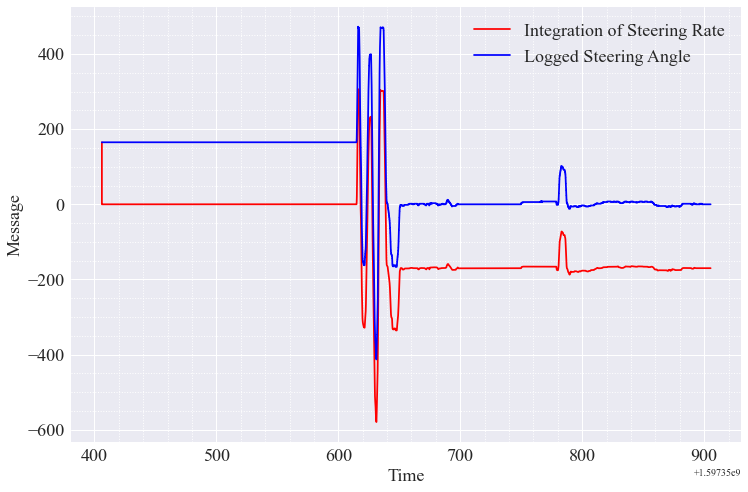

In [59]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (12,8)
params = {'legend.fontsize': 18,
  'legend.handlelength': 2}
plt.rcParams.update(params)
plt.rcParams["font.family"] = "Times New Roman"
fig =plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
ax.grid(which='minor', linestyle=':')
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Message', fontsize=18)
duration=100000
plt.plot(Steering_Rate_Time[0:duration], Steering_Rate_int[0:duration], 'r-', 
         Steering_Angle_Time[0:duration], Steering_Angle_Message[0:duration], 'b-' )
ax.legend(['Integration of Steering Rate', 'Logged Steering Angle' ])

In [60]:
Steering_Rate_int[100:200]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [61]:
Steering_Angle_Message[100:200]

array([165., 165., 165., 165., 165., 165., 165., 165., 165., 165., 165.,
       165., 165., 165., 165., 165., 165., 165., 165., 165., 165., 165.,
       165., 165., 165., 165., 165., 165., 165., 165., 165., 165., 165.,
       165., 165., 165., 165., 165., 165., 165., 165., 165., 165., 165.,
       165., 165., 165., 165., 165., 165., 165., 165., 165., 165., 165.,
       165., 165., 165., 165., 165., 165., 165., 165., 165., 165., 165.,
       165., 165., 165., 165., 165., 165., 165., 165., 165., 165., 165.,
       165., 165., 165., 165., 165., 165., 165., 165., 165., 165., 165.,
       165., 165., 165., 165., 165., 165., 165., 165., 165., 165., 165.,
       165.])

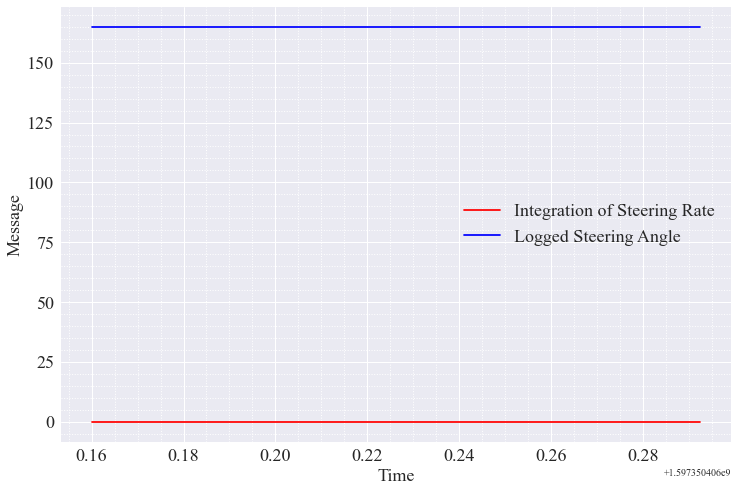

In [62]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (12,8)
params = {'legend.fontsize': 18,
  'legend.handlelength': 2}
plt.rcParams.update(params)
plt.rcParams["font.family"] = "Times New Roman"
fig =plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
ax.grid(which='minor', linestyle=':')
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Message', fontsize=18)

plt.plot(Steering_Rate_Time[100:200], Steering_Rate_int[100:200], 'r-', Steering_Angle_Time[100:200], Steering_Angle_Message[100:200], 'b-' )
ax.legend(['Integration of Steering Rate', 'Logged Steering Angle' ])

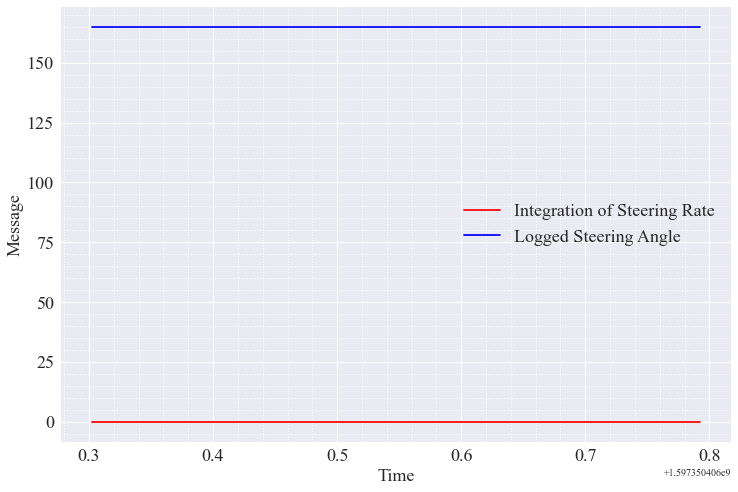

In [63]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (12,8)
params = {'legend.fontsize': 18,
  'legend.handlelength': 2}
plt.rcParams.update(params)
plt.rcParams["font.family"] = "Times New Roman"
fig =plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
ax.grid(which='minor', linestyle=':')
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Message', fontsize=18)

plt.plot(Steering_Rate_Time[200:300], Steering_Rate_int[200:300], 'r-', Steering_Angle_Time[200:300], Steering_Angle_Message[200:300], 'b-' )
ax.legend(['Integration of Steering Rate', 'Logged Steering Angle' ])

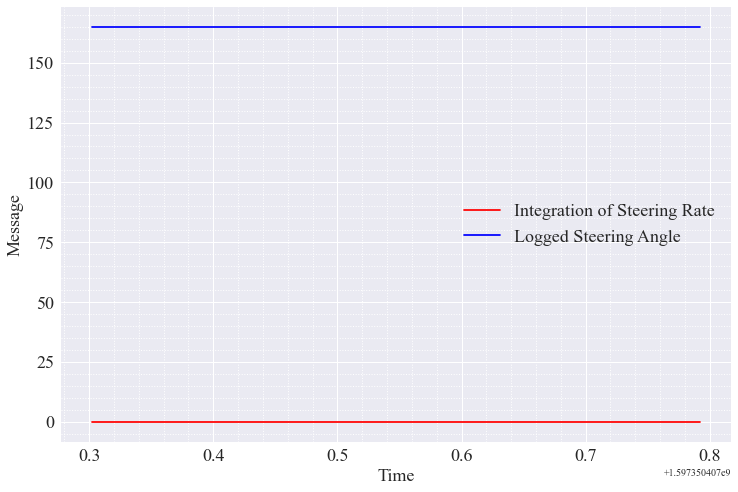

In [64]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (12,8)
params = {'legend.fontsize': 18,
  'legend.handlelength': 2}
plt.rcParams.update(params)
plt.rcParams["font.family"] = "Times New Roman"
fig =plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
ax.minorticks_on()
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
ax.grid(which='minor', linestyle=':')
ax.set_xlabel('Time', fontsize=18)
ax.set_ylabel('Message', fontsize=18)

plt.plot(Steering_Rate_Time[400:500], Steering_Rate_int[400:500], 'r-', Steering_Angle_Time[400:500], Steering_Angle_Message[400:500], 'b-' )
ax.legend(['Integration of Steering Rate', 'Logged Steering Angle' ])

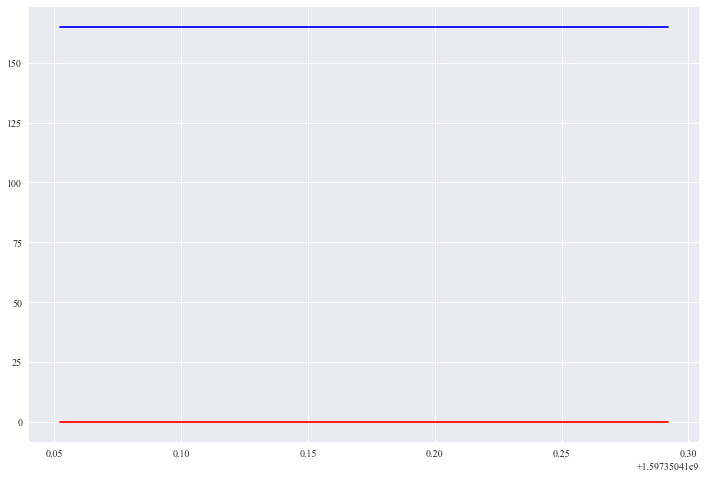

In [65]:
plt.plot(Steering_Rate_Time[950:1000], Steering_Rate_int[950:1000], 'r-', Steering_Angle_Time[950:1000], Steering_Angle_Message[950:1000], 'b-' )


## Experimental

(1501, 2)

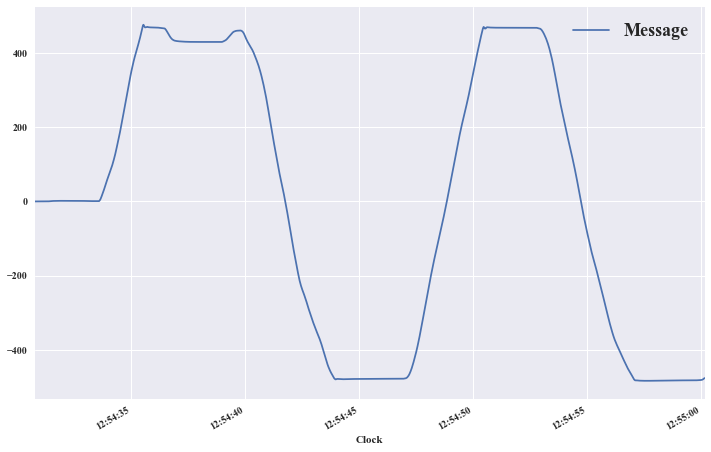

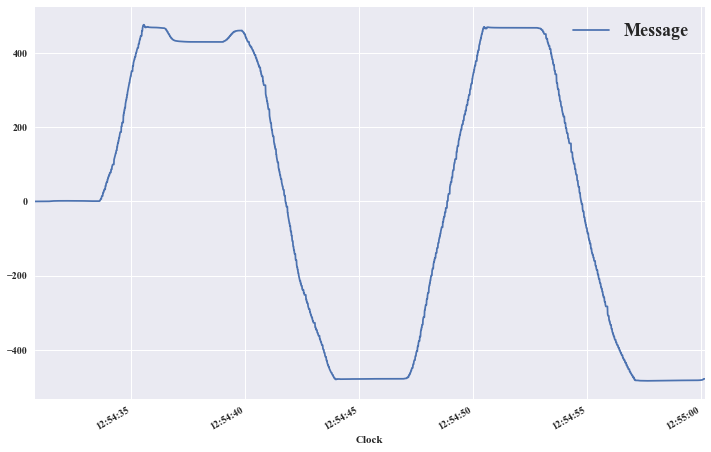

In [21]:
newdf = pd.DataFrame()
newdf['Time'] = decimalData_STEER_RATE['Time']
newdf['Message'] = Steering_Rate_int
newdf['ClockTime'] = newdf['Time'].apply(dateparse)
newdf
#days = pd.to_datetime(newdf['ClockTime'], unit='ns')
Time = pd.to_datetime(newdf['Time'], unit='s')

type(Time.dt.tz_localize('UTC'))
newdf['Clock'] = pd.DatetimeIndex(Time).tz_localize('UTC').tz_convert('US/Mountain')
newdf
newdf = newdf.set_index('Clock')
newdf
new2D = newdf.resample('10ms').ffill()
newdf  = newdf.drop(['Time'], axis = 1)
newdf.plot()
data_rate = 51.65
sampler = (1.0/data_rate)*1000.0
sampler = str(int(sampler)) + "ms"
new2D  = new2D.drop(['Time'], axis = 1)
new2D.plot()
newdf.shape